In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Load data
base_path = "/home/tvanhout/oxides_ML/models"
directory = "test_training/test2"

df_training     = pd.read_csv(os.path.join(base_path, directory , "training.csv"))
df_train_set    = pd.read_csv(os.path.join(base_path, directory , "train_set.csv")) 
df_test_set     = pd.read_csv(os.path.join(base_path, directory , "test_set.csv"))
df_val_set      = pd.read_csv(os.path.join(base_path, directory , "validation_set.csv"))
df_uq           = pd.read_csv(os.path.join(base_path, directory , "uq.csv"))

## Performance metrics

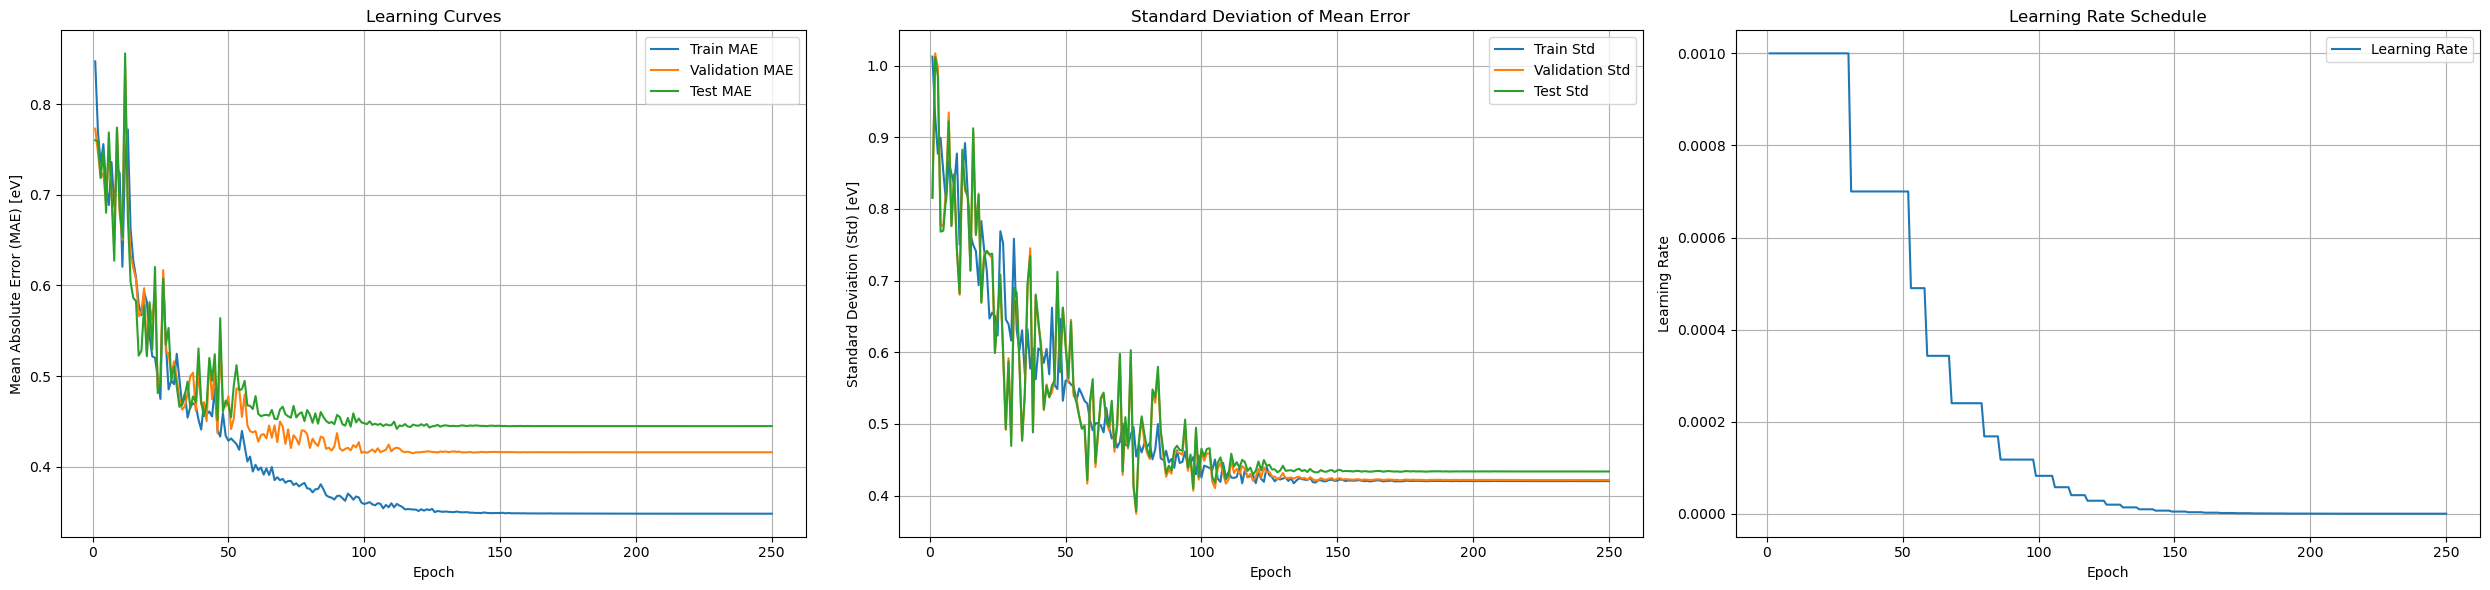

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Learning Curves (Train, Val, Test MAE)
axs[0].plot(df_training['Epoch'], df_training['Train_MAE_eV'], label='Train MAE')
axs[0].plot(df_training['Epoch'], df_training['Val_MAE_eV'], label='Validation MAE')
axs[0].plot(df_training['Epoch'], df_training['Test_MAE_eV'], label='Test MAE')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error (MAE) [eV]')
axs[0].set_title('Learning Curves')
axs[0].legend()
axs[0].grid(True)

# Standard Deviation of Predictions (Train, Val, Test Std)
axs[1].plot(df_training['Epoch'], df_training['Train_std_eV'], label='Train Std')
axs[1].plot(df_training['Epoch'], df_training['Val_std_eV'], label='Validation Std')
axs[1].plot(df_training['Epoch'], df_training['Test_std_eV'], label='Test Std')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Standard Deviation (Std) [eV]')
axs[1].set_title('Standard Deviation of Mean Error')
axs[1].legend()
axs[1].grid(True)

# Learning Rate Schedule
axs[2].plot(df_training['Epoch'], df_training['Learning_Rate'], label='Learning Rate')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


##  Evaluation of the test set

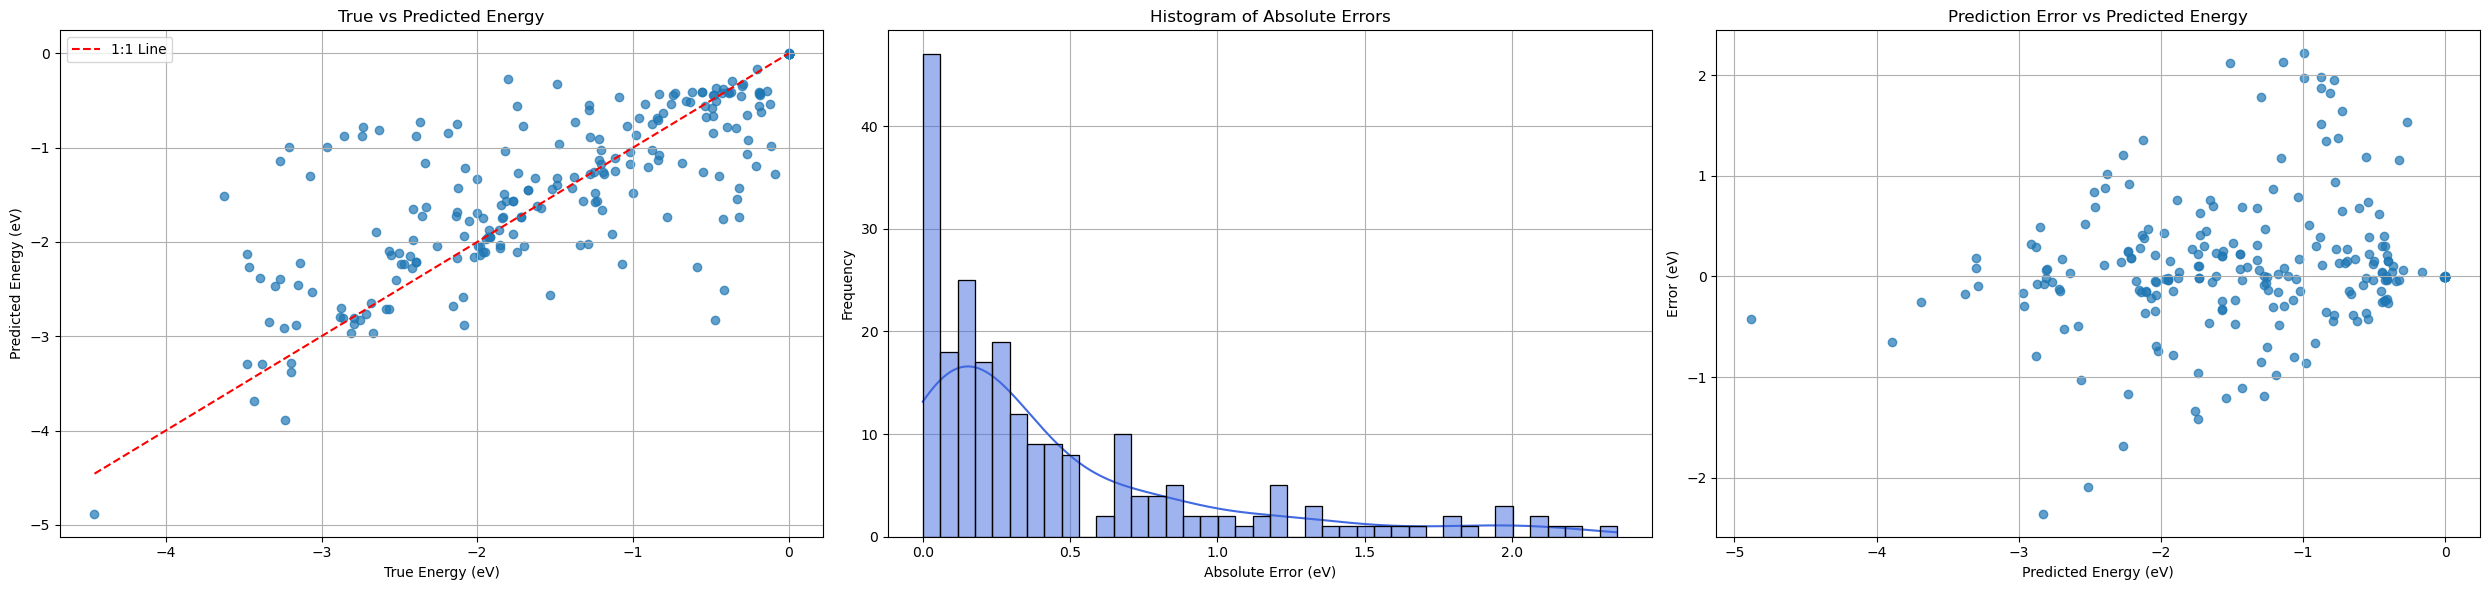

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))  

# True vs. Predicted Energy Plot
axes[0].scatter(df_test_set['True_eV'], df_test_set['Prediction_eV'], alpha=0.7)
axes[0].plot([min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             [min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             'r--', label='1:1 Line')
axes[0].set_xlabel('True Energy (eV)')
axes[0].set_ylabel('Predicted Energy (eV)')
axes[0].set_title('True vs Predicted Energy')
axes[0].legend()
axes[0].grid(True)

# Histogram of Absolute Errors
sns.histplot(df_test_set['Abs_error_eV'], bins=40, kde=True, color='royalblue', ax=axes[1], zorder = 10)
axes[1].set_xlabel('Absolute Error (eV)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Absolute Errors')
axes[1].grid(True)

# Prediction Error vs. Predicted Energy
axes[2].scatter(df_test_set['Prediction_eV'], df_test_set['Error_eV'], alpha=0.7)
axes[2].set_xlabel('Predicted Energy (eV)')
axes[2].set_ylabel('Error (eV)')
axes[2].set_title('Prediction Error vs Predicted Energy')
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Uncertainty quantification

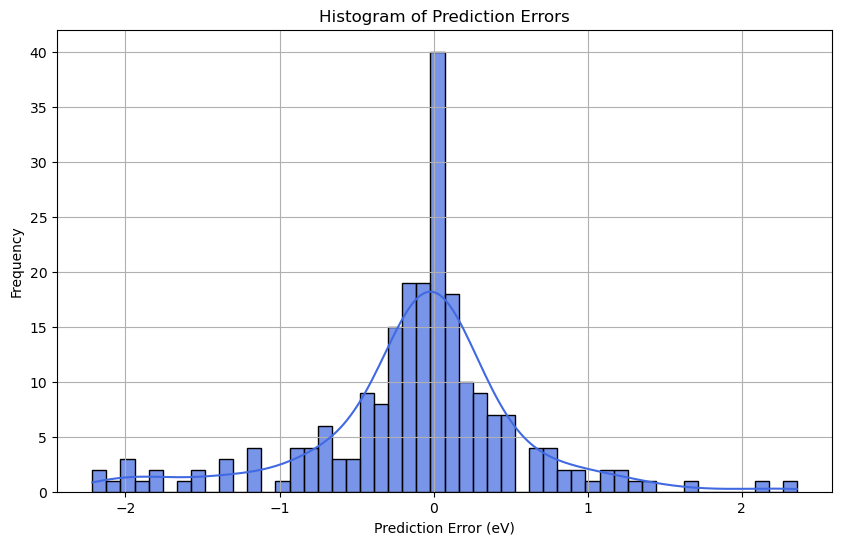

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(df_uq['error'], bins=50, kde = True, color='royalblue', alpha=0.7)

plt.xlabel('Prediction Error (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.grid(True)
plt.show()


## Evaluation of test set per Molecule Group

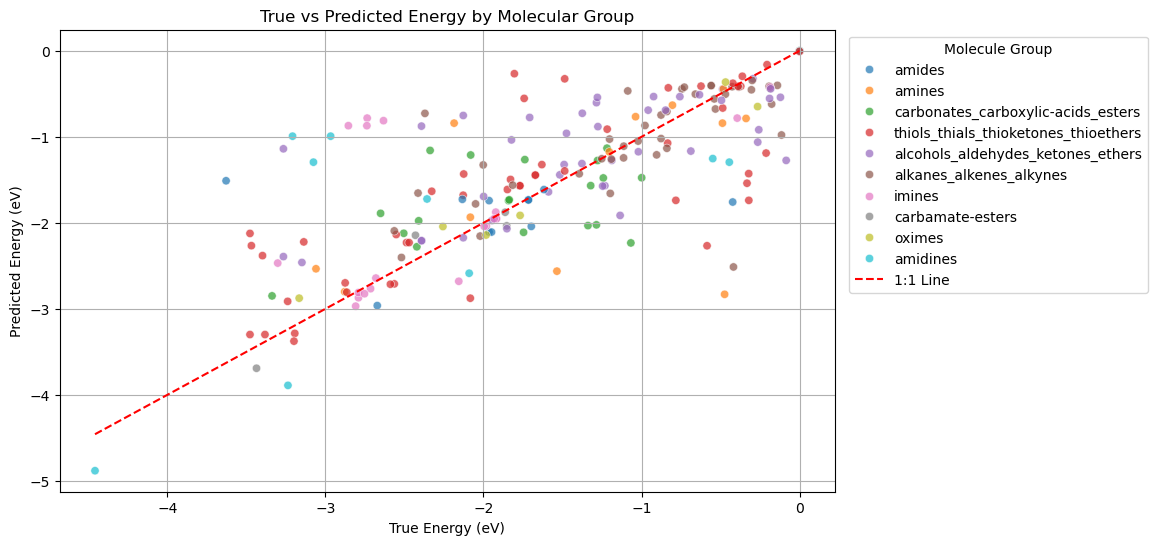

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_test_set, x='True_eV', y='Prediction_eV', hue='Molecule Group', alpha=0.7)
plt.plot([df_test_set['True_eV'].min(), df_test_set['True_eV'].max()], 
         [df_test_set['True_eV'].min(), df_test_set['True_eV'].max()], 
         'r--', label='1:1 Line')

plt.xlabel('True Energy (eV)')
plt.ylabel('Predicted Energy (eV)')
plt.title('True vs Predicted Energy by Molecular Group')
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)

plt.show()


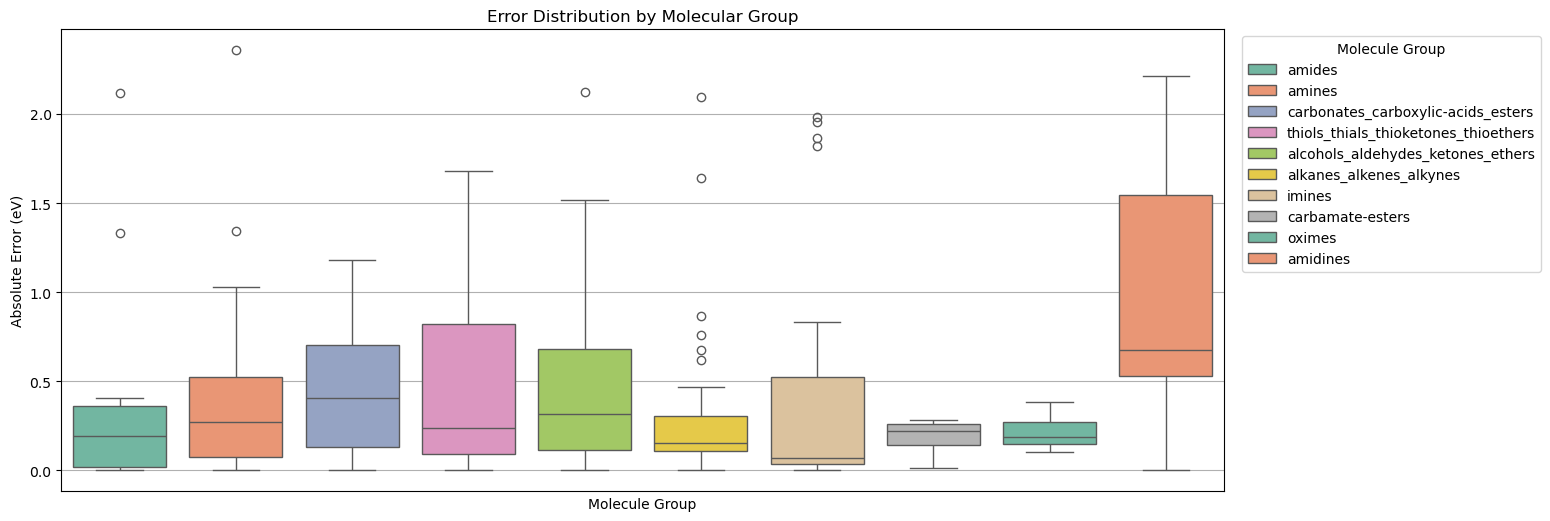

In [20]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_test_set, x='Molecule Group', y='Abs_error_eV', hue='Molecule Group', palette="Set2",legend=True)

plt.xlabel('Molecule Group')
plt.ylabel('Absolute Error (eV)')
plt.title('Error Distribution by Molecular Group')
#plt.xticks(rotation=45)
plt.xticks([])
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.show()


## Uncertainty Qualification per Molecule Group

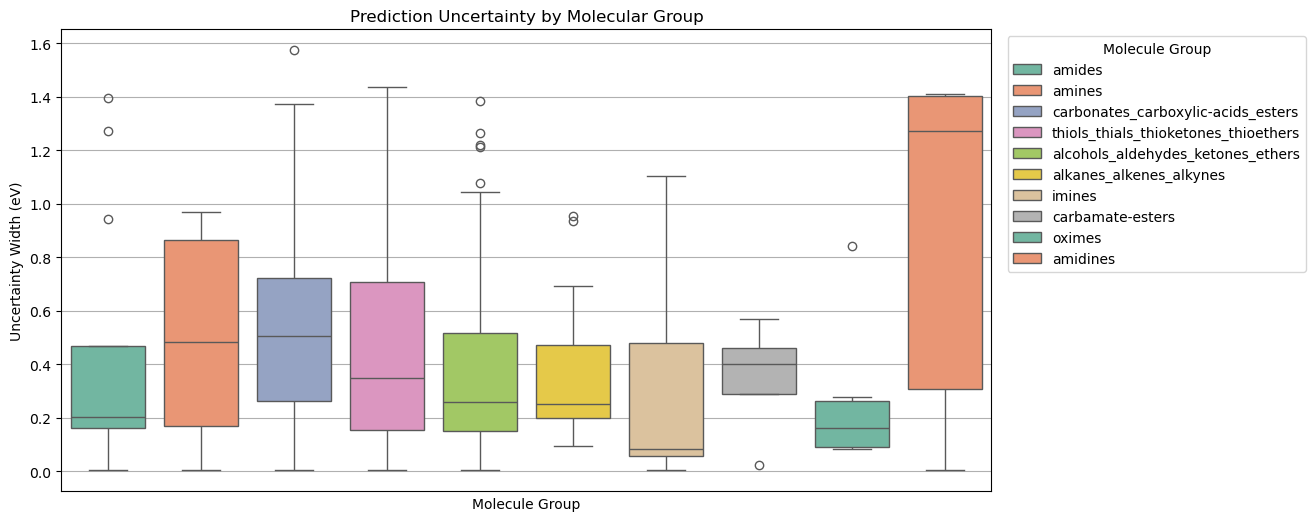

In [22]:
df_uq['uncertainty_width'] = df_uq['y_std']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_uq, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette="Set2", legend=True)

plt.xlabel('Molecule Group')
plt.ylabel('Uncertainty Width (eV)')
plt.title('Prediction Uncertainty by Molecular Group')
#plt.xticks(rotation=45)
plt.xticks([])
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.show()


In [23]:
df_uq.sort_values(["y_true"], ascending=True).head(15)

,formula,material,surface,molecule_group,molecule,y_true,y_mean,error,y_std,y_min,y_max,in_interval,norm_res,uncertainty_width
202,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,-4.457949,-4.882405,0.424457,0.010563,-4.903108,-4.861702,False,40.185040,0.010563
96,CH3Ir40NO81,IrO2,110.0,amides,Formamide,-3.628545,-1.511183,-2.117362,1.394516,-4.244434,1.222068,True,-1.518349,1.394516
23,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-3.477344,-3.299024,-0.178320,0.154368,-3.601586,-2.996462,True,-1.155161,0.154368
3,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-3.477344,-2.123298,-1.354046,1.438146,-4.942063,0.695468,True,-0.941522,1.438146
121,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-3.468439,-2.265713,-1.202727,0.939199,-4.106543,-0.424882,True,-1.280587,0.939199
122,CH3Ir40NO82,IrO2,110.0,carbamate-esters,Carbamic-acid,-3.436062,-3.690940,0.254878,0.024542,-3.739042,-3.642838,False,10.385384,0.024542
155,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-3.398101,-2.381467,-1.016634,0.784343,-3.918779,-0.844154,True,-1.296159,0.784343
149,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-3.382555,-3.299024,-0.083531,0.154368,-3.601586,-2.996462,True,-0.541115,0.154368
219,CH2Ir40O82,IrO2,110.0,carbonates_carboxylic-acids_esters,Formic-acid,-3.337725,-2.849498,-0.488227,0.211674,-3.264378,-2.434618,False,-2.306509,0.211674
22,C2H5Ir40NO80,IrO2,110.0,imines,N-methylmethanimine,-3.301773,-2.468135,-0.833638,0.419206,-3.289778,-1.646492,False,-1.988614,0.419206


In [24]:
df_uq.sort_values(["y_std"], ascending=False).head(20)

,formula,material,surface,molecule_group,molecule,y_true,y_mean,error,y_std,y_min,y_max,in_interval,norm_res,uncertainty_width
75,CH2Ir40O83,IrO2,110.0,carbonates_carboxylic-acids_esters,Carbonic-acid,-1.218431,-1.132057,-0.086374,1.573331,-4.215786,1.951673,True,-0.054899,1.573331
3,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-3.477344,-2.123298,-1.354046,1.438146,-4.942063,0.695468,True,-0.941522,1.438146
93,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,-3.075857,-1.294882,-1.780975,1.410570,-4.059599,1.469835,True,-1.262593,1.410570
168,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,-0.444483,-1.294882,0.850398,1.410570,-4.059599,1.469835,True,0.602876,1.410570
145,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,-0.549138,-1.253207,0.704069,1.405841,-4.008656,1.502242,True,0.500817,1.405841
96,CH3Ir40NO81,IrO2,110.0,amides,Formamide,-3.628545,-1.511183,-2.117362,1.394516,-4.244434,1.222068,True,-1.518349,1.394516
179,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,-2.966956,-0.992675,-1.974282,1.388768,-3.714659,1.729310,True,-1.421607,1.388768
203,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,-3.208014,-0.992675,-2.215340,1.388768,-3.714659,1.729310,True,-1.595184,1.388768
162,C2H4Ir40O81,IrO2,110.0,alcohols_aldehydes_ketones_ethers,Acetaldehyde,-1.822704,-1.036021,-0.786683,1.385102,-3.750822,1.678780,True,-0.567960,1.385102
17,C2H4Ir40O82,IrO2,110.0,carbonates_carboxylic-acids_esters,Acetic-acid,-2.337632,-1.158330,-1.179302,1.373856,-3.851089,1.534428,True,-0.858388,1.373856


In [25]:
df_uq.sort_values(["error"], ascending=True).head(15)

,formula,material,surface,molecule_group,molecule,y_true,y_mean,error,y_std,y_min,y_max,in_interval,norm_res,uncertainty_width
203,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,-3.208014,-0.992675,-2.215340,1.388768,-3.714659,1.729310,True,-1.595184,1.388768
158,C2H4Ir40O81,IrO2,110.0,alcohols_aldehydes_ketones_ethers,Acetaldehyde,-3.265855,-1.139463,-2.126392,1.211652,-3.514302,1.235375,True,-1.754952,1.211652
96,CH3Ir40NO81,IrO2,110.0,amides,Formamide,-3.628545,-1.511183,-2.117362,1.394516,-4.244434,1.222068,True,-1.518349,1.394516
87,C3H7Ir40NO80,IrO2,110.0,imines,Propan-2-imine,-2.854844,-0.870718,-1.984126,1.028270,-2.886127,1.144691,True,-1.929577,1.028270
179,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,-2.966956,-0.992675,-1.974282,1.388768,-3.714659,1.729310,True,-1.421607,1.388768
61,C2H5Ir40NO80,IrO2,110.0,imines,Ethanimine,-2.735771,-0.782650,-1.953121,1.101857,-2.942290,1.376991,True,-1.772571,1.101857
196,C3H7Ir40NO80,IrO2,110.0,imines,Propan-2-imine,-2.737653,-0.870718,-1.866935,1.028270,-2.886127,1.144691,True,-1.815608,1.028270
153,C2H5Ir40NO80,IrO2,110.0,imines,N-methylmethanimine,-2.632511,-0.812334,-1.820176,1.103487,-2.975170,1.350501,True,-1.649476,1.103487
93,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,-3.075857,-1.294882,-1.780975,1.410570,-4.059599,1.469835,True,-1.262593,1.410570
81,C2H4Ir40O80,IrO2,110.0,alkanes_alkenes_alkynes,Ethene,-2.370340,-0.727501,-1.642839,0.633005,-1.968191,0.513189,False,-2.595301,0.633005
